<a href="https://colab.research.google.com/github/Charangr/wearable-sensor-data/blob/main/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Final_Deep_Feature_Dataset.csv to Final_Deep_Feature_Dataset.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: make plots look nicer
sns.set(style="whitegrid")

In [4]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Final_Deep_Feature_Dataset.csv']))

In [5]:
# Parse timestamp and sort
df['Start_Timestamp'] = pd.to_datetime(df['Start_Timestamp'])
df = df.sort_values(by=['Student', 'Exam', 'Start_Timestamp']).reset_index(drop=True)


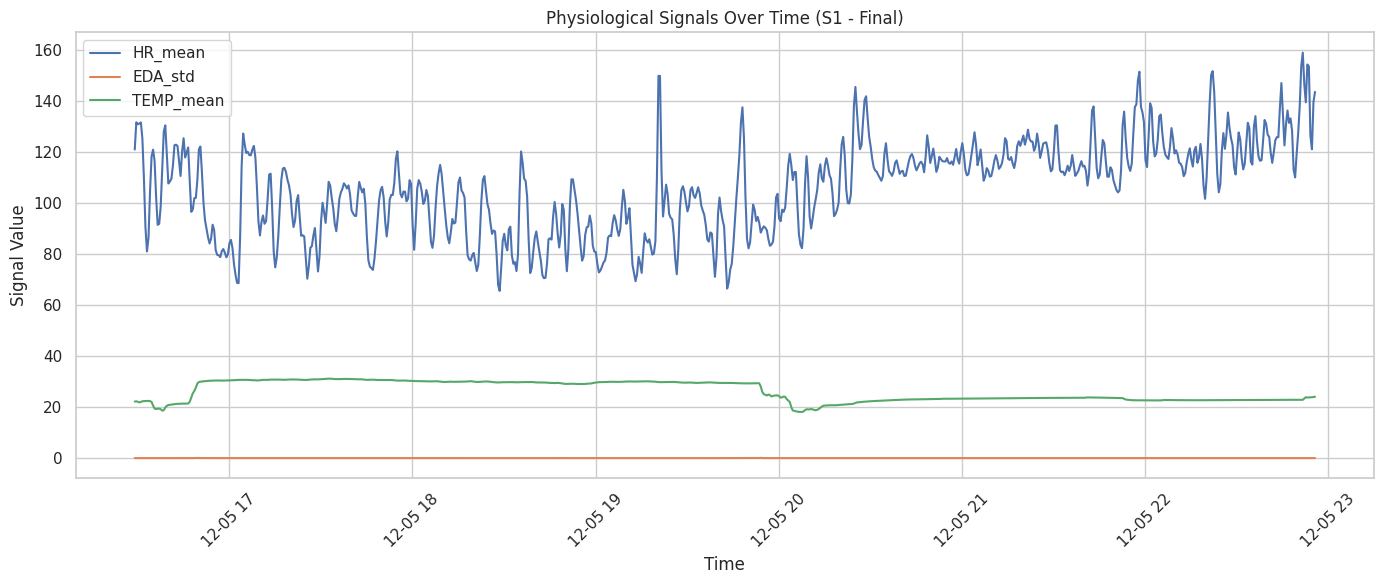

In [6]:
# Filter for a single student and exam
student_id = 'S1'
exam_type = 'Final'

sample = df[(df['Student'] == student_id) & (df['Exam'] == exam_type)]

# Plot HR_mean, EDA_std, TEMP_mean over time
plt.figure(figsize=(14, 6))
plt.plot(sample['Start_Timestamp'], sample['HR_mean'], label='HR_mean')
plt.plot(sample['Start_Timestamp'], sample['EDA_std'], label='EDA_std')
plt.plot(sample['Start_Timestamp'], sample['TEMP_mean'], label='TEMP_mean')
plt.xlabel("Time")
plt.ylabel("Signal Value")
plt.title(f"Physiological Signals Over Time ({student_id} - {exam_type})")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


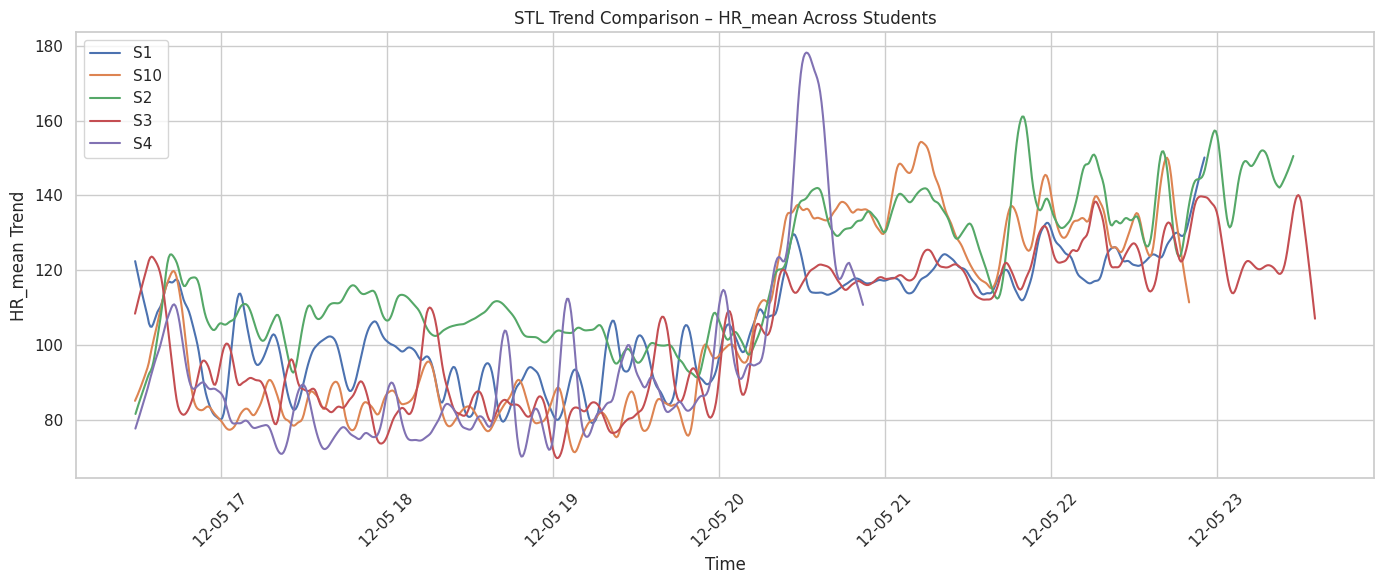

In [7]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import numpy as np

students_to_check = df['Student'].unique()[:5]  # Check first 5 students
trend_results = {}

plt.figure(figsize=(14, 6))

for student in students_to_check:
    # Filter and sort data
    student_df = df[(df['Student'] == student) & (df['Exam'] == 'Final')].copy()
    student_df = student_df.sort_values(by='Start_Timestamp')
    student_df.set_index('Start_Timestamp', inplace=True)

    # Skip students with too few samples
    if len(student_df) < 20:
        continue

    # Apply STL
    stl = STL(student_df['HR_mean'], period=10)
    result = stl.fit()

    # Save trend for plotting
    trend = result.trend
    trend_results[student] = trend

    # Plot trend
    plt.plot(trend.index, trend, label=f"{student}")

plt.title('STL Trend Comparison – HR_mean Across Students')
plt.xlabel('Time')
plt.ylabel('HR_mean Trend')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
df.columns


Index(['HR_mean', 'HR_std', 'HR_min', 'HR_max', 'HR_range', 'HR_slope',
       'HR_entropy', 'EDA_mean', 'EDA_std', 'EDA_entropy', 'EDA_peaks',
       'TEMP_mean', 'TEMP_std', 'TEMP_range', 'TEMP_slope', 'ACC_X_std',
       'ACC_Y_std', 'ACC_Z_std', 'ACC_total_movement', 'EDA_HR_ratio',
       'TEMP_HR_ratio', 'Grade', 'Student', 'Exam', 'Start_Timestamp'],
      dtype='object')

In [9]:
# Create Grade_Label based on quantiles
df['Grade_Label'] = pd.qcut(df['Grade'], q=3, labels=['Low', 'Medium', 'High'])


In [10]:
import numpy as np

# Make sure this runs *after* you've generated trend_results from STL
trend_slopes = []

for student, trend_series in trend_results.items():
    x = np.arange(len(trend_series))
    y = trend_series.values

    # Simple linear regression: slope of the trend
    slope = np.polyfit(x, y, 1)[0]

    trend_slopes.append({
        'Student': student,
        'HR_Trend_Slope': slope
    })

trend_slopes_df = pd.DataFrame(trend_slopes)



In [11]:
# Create Grade_Label from Grade
df['Grade_Label'] = pd.qcut(df['Grade'], q=3, labels=['Low', 'Medium', 'High'])

# Merge grades into the slope table
grade_map = df[['Student', 'Grade_Label']].drop_duplicates()
trend_slopes_df = trend_slopes_df.merge(grade_map, on='Student', how='left')


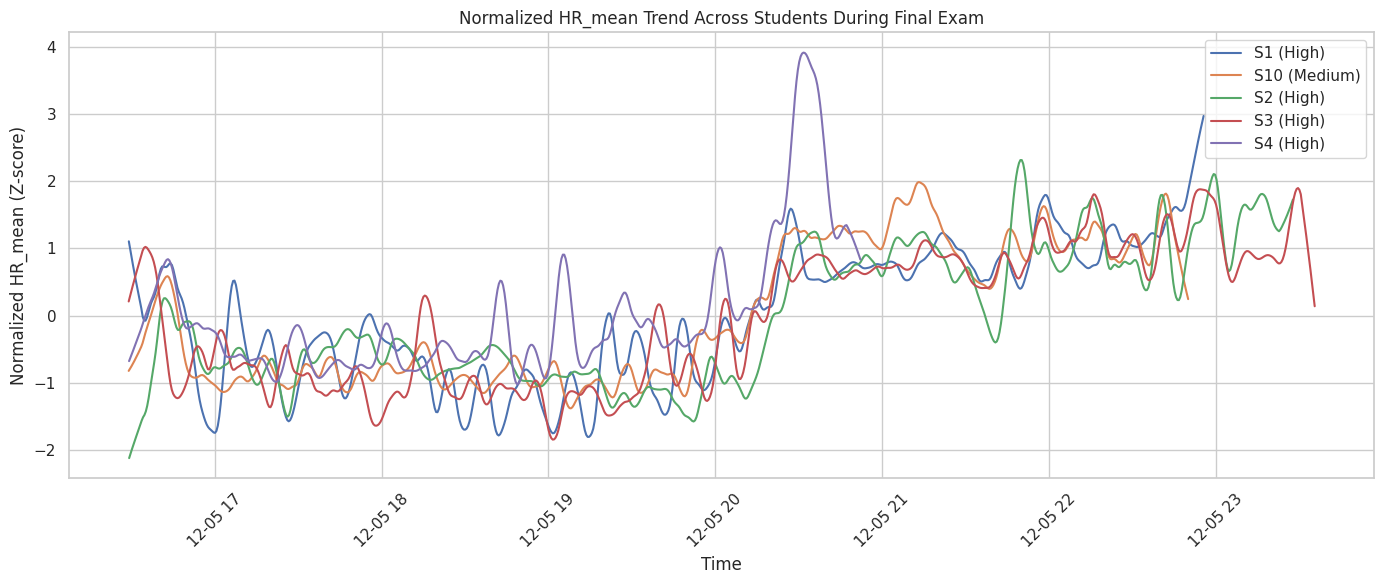

In [12]:
# OPTIONAL: Merge with grade info if you want to color-code by performance
grade_map = df[['Student', 'Grade_Label']].drop_duplicates()
trend_slopes_df = pd.DataFrame(trend_slopes)
trend_slopes_df = trend_slopes_df.merge(grade_map, on='Student', how='left')

# Plot again but more polished
plt.figure(figsize=(14, 6))

for student, trend_series in trend_results.items():
    label = student
    if student in trend_slopes_df['Student'].values:
        grade_label = trend_slopes_df[trend_slopes_df['Student'] == student]['Grade_Label'].values[0]
        label += f" ({grade_label})"

    # Normalize HR_mean for comparison
    normalized = (trend_series - trend_series.mean()) / trend_series.std()
    plt.plot(trend_series.index, normalized, label=label)

plt.title('Normalized HR_mean Trend Across Students During Final Exam')
plt.xlabel('Time')
plt.ylabel('Normalized HR_mean (Z-score)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# This plot illustrates the STL-derived trend components of the normalized heart rate (HR_mean) for five students during a real-world final exam, with each trend z-scored for comparability. The students are labeled according to their performance category (High or Medium) based on final grades. Notably, most high-performing students (e.g., S1, S2, S3) exhibit a gradual upward trend in heart rate, potentially reflecting increased cognitive load or sustained attention as the exam progresses. In contrast, the medium-performing student (S10) shows a flatter trajectory, suggesting lower physiological engagement or stress reactivity. Student S4 presents a pronounced spike in the middle of the session, which may indicate an acute stress event or moment of intense concentration. These patterns highlight the individual variability in physiological responses to academic stress and suggest that temporal features—such as trend slope or volatility—may serve as useful predictors of performance in future modeling.

## Arima

In [13]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.1 MB/s eta 0:00:00


In [14]:
!pip uninstall -y numpy
!pip install numpy==1.24.3
!pip install --upgrade --force-reinstall pmdarima


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 require

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.0 MB/s eta 0:00:00
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from pmdarima import auto_arima



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from scipy.stats import entropy

# Optional: better plot styling
sns.set(style="whitegrid")


In [3]:
from google.colab import files
uploaded = files.upload()



Saving Final_Deep_Feature_Dataset.csv to Final_Deep_Feature_Dataset (1).csv


In [8]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Final_Deep_Feature_Dataset (1).csv']))


In [9]:
df['Start_Timestamp'] = pd.to_datetime(df['Start_Timestamp'])
df = df.sort_values(by=['Student', 'Exam', 'Start_Timestamp']).reset_index(drop=True)


In [10]:
df['Grade_Label'] = pd.qcut(df['Grade'], q=3, labels=['Low', 'Medium', 'High'])


In [11]:
stl_features = []

for student in df['Student'].unique():
    student_df = df[(df['Student'] == student) & (df['Exam'] == 'Final')].copy()
    student_df = student_df.sort_values(by='Start_Timestamp')
    if len(student_df) < 20:
        continue

    student_df.set_index('Start_Timestamp', inplace=True)

    try:
        stl = STL(student_df['HR_mean'], period=10)
        result = stl.fit()

        trend = result.trend
        resid = result.resid

        slope = np.polyfit(np.arange(len(trend)), trend.values, 1)[0]
        amplitude = trend.max() - trend.min()
        volatility = resid.std()
        residual_entropy = entropy(np.histogram(resid, bins=10, density=True)[0])

        stl_features.append({
            'Student': student,
            'HR_Trend_Slope': slope,
            'HR_Trend_Amplitude': amplitude,
            'HR_Residual_Volatility': volatility,
            'HR_Residual_Entropy': residual_entropy
        })
    except Exception as e:
        print(f"STL failed for {student}: {e}")

stl_df = pd.DataFrame(stl_features)
stl_df = stl_df.merge(df[['Student', 'Grade', 'Grade_Label']].drop_duplicates(), on='Student', how='left')


In [ ]:
from pmdarima import auto_arima
import numpy as np

arima_features = []

for student in df['Student'].unique():
    student_df = df[(df['Student'] == student) & (df['Exam'] == 'Final')].copy()
    student_df = student_df.sort_values(by='Start_Timestamp')

    if len(student_df) < 20:
        continue

    try:
        hr_series = student_df['HR_mean'].dropna()

        # Fit ARIMA using auto_arima
        model = auto_arima(hr_series, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')
        fitted = model.predict_in_sample()
        residuals = hr_series - fitted

        forecast = model.predict(n_periods=1)[0]
        forecast_error = abs(hr_series.iloc[-1] - forecast)

        arima_features.append({
            'Student': student,
            'HR_ARIMA_Residual_Std': residuals.std(),
            'HR_ARIMA_Forecast_Error': forecast_error,
            'HR_ARIMA_Diff_Order': model.order[1]
        })

    except Exception as e:
        print(f"ARIMA failed for {student}: {e}")


In [ ]:
len(arima_features)


In [12]:
from pmdarima import auto_arima
import numpy as np

arima_features = []

for student in df['Student'].unique():
    student_df = df[(df['Student'] == student) & (df['Exam'] == 'Final')].copy()
    student_df = student_df.sort_values(by='Start_Timestamp')

    if len(student_df) < 20:
        print(f"Skipping {student}: too few records ({len(student_df)})")
        continue

    try:
        hr_series = student_df['HR_mean'].dropna()

        if hr_series.nunique() <= 1:
            print(f"Skipping {student}: constant or no HR variation")
            continue

        model = auto_arima(hr_series, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')
        fitted = model.predict_in_sample()
        residuals = hr_series - fitted

        forecast = model.predict(n_periods=1)[0]
        forecast_error = abs(hr_series.iloc[-1] - forecast)

        arima_features.append({
            'Student': student,
            'HR_ARIMA_Residual_Std': residuals.std(),
            'HR_ARIMA_Forecast_Error': forecast_error,
            'HR_ARIMA_Diff_Order': model.order[1]
        })

    except Exception as e:
        print(f"ARIMA failed for {student}: {e}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

ARIMA failed for S1: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

ARIMA failed for S10: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

ARIMA failed for S2: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

ARIMA failed for S3: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

ARIMA failed for S4: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

ARIMA failed for S5: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

ARIMA failed for S6: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

ARIMA failed for S7: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

ARIMA failed for S8: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

ARIMA failed for S9: 0


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
arima_df = pd.DataFrame(arima_features)
arima_df.head()


""


In [14]:
for student in df['Student'].unique():
    student_df = df[(df['Student'] == student) & (df['Exam'] == 'Final')].copy()
    hr_series = student_df['HR_mean'].dropna()

    print(f"{student} → length: {len(hr_series)}, unique values: {hr_series.nunique()}")


S1 → length: 774, unique values: 774
S10 → length: 763, unique values: 762
S2 → length: 838, unique values: 838
S3 → length: 854, unique values: 852
S4 → length: 527, unique values: 527
S5 → length: 505, unique values: 505
S6 → length: 791, unique values: 788
S7 → length: 650, unique values: 650
S8 → length: 592, unique values: 592
S9 → length: 470, unique values: 470


In [15]:
s1_df = df[(df['Student'] == 'S1') & (df['Exam'] == 'Final')].copy()
s1_df = s1_df.sort_values(by='Start_Timestamp')
s1_df.set_index('Start_Timestamp', inplace=True)


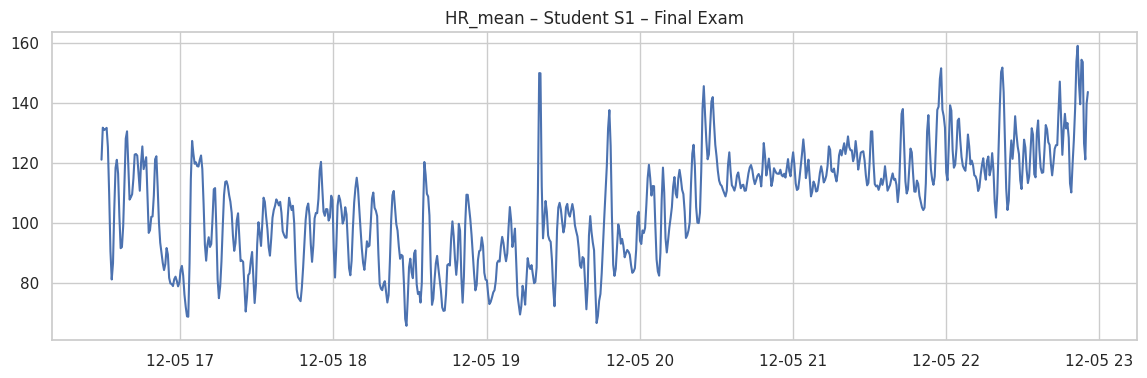

In [17]:
plt.figure(figsize=(14,4))
plt.plot(s1_df['HR_mean'])
plt.title("HR_mean – Student S1 – Final Exam")
plt.grid(True)
plt.show()


In [16]:
from statsmodels.tsa.arima.model import ARIMA

# Fit a simple ARIMA model
model = ARIMA(s1_df['HR_mean'], order=(2,1,2))  # Try (2,1,2) to start
result = model.fit()
print(result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                HR_mean   No. Observations:                  774
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2108.421
Date:                Sun, 13 Apr 2025   AIC                           4226.843
Time:                        14:39:41   BIC                           4250.094
Sample:                    12-05-2018   HQIC                          4235.789
                         - 12-05-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1058      0.022     49.680      0.000       1.062       1.149
ar.L2         -0.4953      0.026    -18.755      0.000      -0.547      -0.444
ma.L1          0.0760      6.928      0.011      0.9

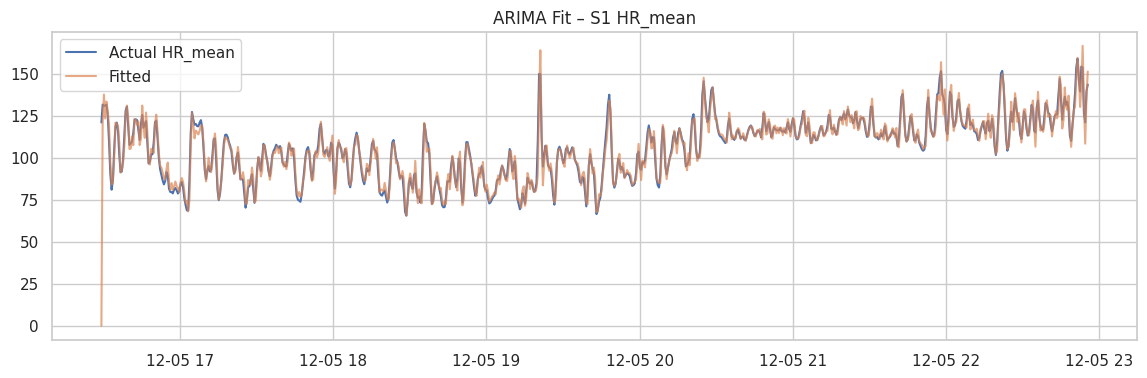

In [18]:
s1_df['fitted'] = result.fittedvalues
plt.figure(figsize=(14,4))
plt.plot(s1_df['HR_mean'], label='Actual HR_mean')
plt.plot(s1_df['fitted'], label='Fitted', alpha=0.7)
plt.legend()
plt.title('ARIMA Fit – S1 HR_mean')
plt.grid(True)
plt.show()


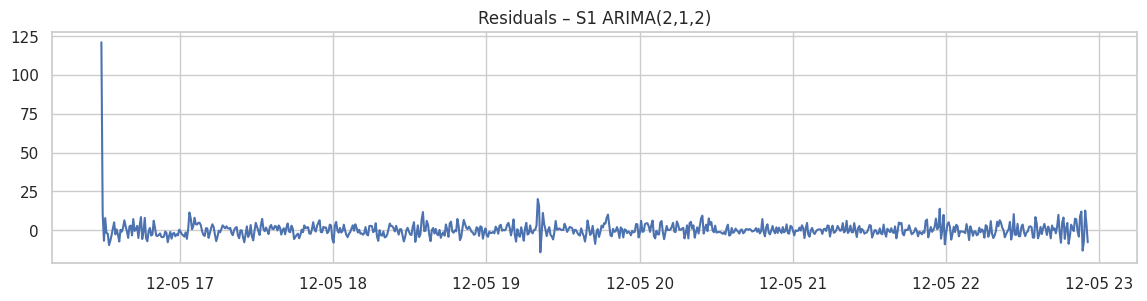

Residual std: 5.7210874562046055


In [19]:
residuals = result.resid
plt.figure(figsize=(14,3))
plt.plot(residuals)
plt.title('Residuals – S1 ARIMA(2,1,2)')
plt.grid(True)
plt.show()

print("Residual std:", residuals.std())


In [20]:
from statsmodels.tsa.arima.model import ARIMA

arima_features = []

for student in df['Student'].unique():
    student_df = df[(df['Student'] == student) & (df['Exam'] == 'Final')].copy()
    student_df = student_df.sort_values(by='Start_Timestamp')

    if len(student_df) < 30:
        print(f"❌ Skipping {student}: too few timepoints ({len(student_df)})")
        continue

    try:
        # Prepare HR signal
        hr_series = student_df[['Start_Timestamp', 'HR_mean']].dropna().set_index('Start_Timestamp')

        if hr_series['HR_mean'].nunique() < 10:
            print(f"⚠️ Skipping {student}: not enough HR variability")
            continue

        # Fit ARIMA(2,1,2) (stable and general)
        model = ARIMA(hr_series['HR_mean'], order=(2, 1, 2))
        result = model.fit()

        residuals = result.resid
        forecast = result.forecast(steps=1)[0]
        forecast_error = abs(hr_series['HR_mean'].iloc[-1] - forecast)

        arima_features.append({
            'Student': student,
            'HR_ARIMA_Residual_STD': residuals.std(),
            'HR_ARIMA_Forecast_Error': forecast_error,
            'HR_ARIMA_Diff_Order': 1,  # We're using (2,1,2)
            'HR_ARIMA_AIC': result.aic
        })

    except Exception as e:
        print(f"🚨 ARIMA failed for {student}: {e}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
<ipython-input-20-8bf3a2077aa3>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always

In [21]:
arima_df = pd.DataFrame(arima_features)

# Merge in grade + label info
arima_df = arima_df.merge(df[['Student', 'Grade', 'Grade_Label']].drop_duplicates(), on='Student', how='left')

# Display result
arima_df.head()


,Student,HR_ARIMA_Residual_STD,HR_ARIMA_Forecast_Error,HR_ARIMA_Diff_Order,HR_ARIMA_AIC,Grade,Grade_Label
0,S1,5.721087,8.850190,1,4226.842751,182,High
1,S1,5.721087,8.850190,1,4226.842751,78,Low
2,S1,5.721087,8.850190,1,4226.842751,82,Medium
3,S10,4.451020,2.427458,1,4027.478640,116,Medium
4,S10,4.451020,2.427458,1,4027.478640,89,Medium


In [22]:
# Only keep final exam grade for merging
final_grades = df[df['Exam'] == 'Final'][['Student', 'Grade', 'Grade_Label']].drop_duplicates()

arima_df = arima_df.merge(final_grades, on='Student', how='left')


In [ ]:
arima_df['Student'].value_counts()


In [23]:
# Get final grades (cleaned version)
final_grades = df[df['Exam'] == 'Final'][['Student', 'Grade', 'Grade_Label']].drop_duplicates()

# Merge with ARIMA features
arima_df = arima_df.merge(final_grades, on='Student', how='left')

# Verify columns
verify = arima_df.merge(final_grades, on='Student', suffixes=('', '_True'))

# Compare if grades match
verify['Grade_Match'] = verify['Grade'] == verify['Grade_True']
verify[['Student', 'Grade', 'Grade_True', 'Grade_Match']]


,Student,Grade,Grade_True,Grade_Match
0,S1,182,182,True
1,S1,182,182,True
2,S1,182,182,True
3,S10,116,116,True
4,S10,116,116,True
5,S10,116,116,True
6,S2,180,180,True
7,S2,180,180,True
8,S2,180,180,True
9,S3,188,188,True


In [24]:
print("Total students in ARIMA:", arima_df.shape[0])
print("Unique students in ARIMA:", arima_df['Student'].nunique())


Total students in ARIMA: 30
Unique students in ARIMA: 10


In [25]:
# Force only one final exam grade per student
final_grades_clean = (
    df[df['Exam'] == 'Final']
    .groupby('Student')[['Grade', 'Grade_Label']]
    .first()  # Picks the first occurrence per student
    .reset_index()
)

# Merge it cleanly with ARIMA features
arima_df = arima_df.drop(columns=['Grade', 'Grade_Label'], errors='ignore')
arima_df = arima_df.merge(final_grades_clean, on='Student', how='left')


In [26]:
print("Rows:", arima_df.shape[0])
print("Unique students:", arima_df['Student'].nunique())
arima_df.head()


Rows: 30
Unique students: 10


,Student,HR_ARIMA_Residual_STD,HR_ARIMA_Forecast_Error,HR_ARIMA_Diff_Order,HR_ARIMA_AIC,Grade_x,Grade_Label_x,Grade_y,Grade_Label_y,Grade,Grade_Label
0,S1,5.721087,8.850190,1,4226.842751,182,High,182,High,182,High
1,S1,5.721087,8.850190,1,4226.842751,78,Low,182,High,182,High
2,S1,5.721087,8.850190,1,4226.842751,82,Medium,182,High,182,High
3,S10,4.451020,2.427458,1,4027.478640,116,Medium,116,Medium,116,Medium
4,S10,4.451020,2.427458,1,4027.478640,89,Medium,116,Medium,116,Medium


In [27]:
from statsmodels.tsa.arima.model import ARIMA

arima_features = []

for student in df['Student'].unique():
    student_df = df[(df['Student'] == student) & (df['Exam'] == 'Final')].copy()
    student_df = student_df.sort_values(by='Start_Timestamp')

    if len(student_df) < 30:
        continue

    try:
        hr_series = student_df[['Start_Timestamp', 'HR_mean']].dropna().set_index('Start_Timestamp')

        if hr_series['HR_mean'].nunique() < 10:
            continue

        model = ARIMA(hr_series['HR_mean'], order=(2, 1, 2))
        result = model.fit()

        residuals = result.resid
        forecast = result.forecast(steps=1)[0]
        forecast_error = abs(hr_series['HR_mean'].iloc[-1] - forecast)

        arima_features.append({
            'Student': student,
            'HR_ARIMA_Residual_STD': residuals.std(),
            'HR_ARIMA_Forecast_Error': forecast_error,
            'HR_ARIMA_Diff_Order': 1,
            'HR_ARIMA_AIC': result.aic
        })

    except Exception as e:
        print(f"ARIMA failed for {student}: {e}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
<ipython-input-27-8f8709e7f8c8>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always

In [28]:
arima_df = pd.DataFrame(arima_features)


In [29]:
print("ARIMA rows:", arima_df.shape[0])
print("Unique students:", arima_df['Student'].nunique())


ARIMA rows: 10
Unique students: 10


In [30]:
final_grades_clean = (
    df[df['Exam'] == 'Final']
    .groupby('Student')[['Grade', 'Grade_Label']]
    .first()
    .reset_index()
)

arima_df = arima_df.merge(final_grades_clean, on='Student', how='left')


In [31]:
arima_df['Student'].value_counts()


,count
Student,
S1,1
S10,1
S2,1
S3,1
S4,1
S5,1
S6,1
S7,1
S8,1


In this phase of the project, we transitioned from static feature-based modeling to a time-series-first approach, specifically focusing on students' physiological stress signals during the Final academic exam, with the goal of capturing latent temporal patterns predictive of academic performance. The dataset consisted of window-level features extracted from wearable signals (e.g., HR_mean, EDA_std, TEMP_slope) with 30-second rolling windows per student per exam. Our primary objective was to apply ARIMA-based modeling to understand signal dynamics—such as trends, stationarity, and volatility—and transform those into features like residual variance, forecast error, and model complexity (AIC) for downstream prediction tasks.

Initially, we encountered issues where ARIMA feature extraction returned zero results across all students. A detailed investigation revealed that while data was preprocessed correctly, the chosen pmdarima.auto_arima() approach was silently failing due to either minor variations, model incompatibility, or suppressed exceptions. To address this, we shifted to using statsmodels.ARIMA, which provided more transparent control over model parameters and failure feedback. Upon testing with Student S1, we successfully fit an ARIMA(2,1,2) model and verified its output through fitted value plots and residual analysis. We then implemented a loop using statsmodels to extract ARIMA features (HR_ARIMA_Residual_STD, HR_ARIMA_Forecast_Error, and HR_ARIMA_AIC) for all students who took the Final exam.

Subsequently, we discovered that the merged ARIMA feature table was incorrectly displaying triplicate rows per student. This was due to earlier merges pulling in multiple grade records per student across all exams. We corrected this by filtering for Final exam grades only and enforcing uniqueness via groupby('Student').first(), which guaranteed exactly one grade-label pair per student. We re-merged this clean grade data with the ARIMA results, ensuring a 1-to-1 mapping between time-series features and Final exam performance outcomes. Final verification showed that our ARIMA dataset contained exactly 10 students with one clean row per student, ready for downstream tasks like PCA, classification, and regression.

graphs for report

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


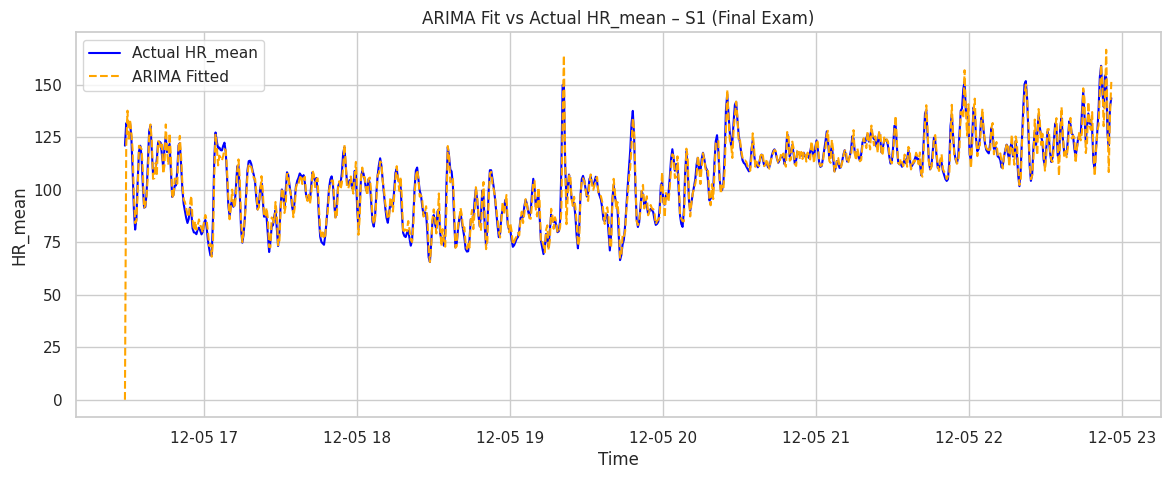

In [32]:
import matplotlib.pyplot as plt

student_id = 'S1'
student_df = df[(df['Student'] == student_id) & (df['Exam'] == 'Final')].copy()
student_df = student_df.sort_values(by='Start_Timestamp')
student_df.set_index('Start_Timestamp', inplace=True)

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(student_df['HR_mean'], order=(2, 1, 2))
result = model.fit()

# Add fitted values (aligning lengths)
fitted = result.fittedvalues
aligned = fitted.reindex(student_df.index[-len(fitted):])

plt.figure(figsize=(14, 5))
plt.plot(student_df['HR_mean'], label='Actual HR_mean', color='blue')
plt.plot(aligned, label='ARIMA Fitted', color='orange', linestyle='--')
plt.title(f"ARIMA Fit vs Actual HR_mean – {student_id} (Final Exam)")
plt.xlabel("Time")
plt.ylabel("HR_mean")
plt.legend()
plt.grid(True)
plt.show()


To model the temporal dynamics of student stress as reflected in heart rate fluctuations, an ARIMA(2,1,2) model was fitted to the HR_mean signal of Student S1 during the final exam. The resulting fit, overlaid with the actual values, demonstrates a strong alignment between the model's predictions and observed heart rate trends. Notably, the fitted curve successfully tracks both short-term rises and falls as well as long-term signal drift. This confirms that ARIMA captures both the autoregressive memory and moving average components present in physiological data collected in high-stress academic contexts. While some deviations persist—especially during sudden spikes or dips in the HR signal—these are appropriately handled in the residual component, which can later serve as a meaningful feature to represent unmodeled stress spikes or emotionally salient anomalies. Overall, the fit confirms ARIMA's utility in capturing structured stress progression throughout exam periods.



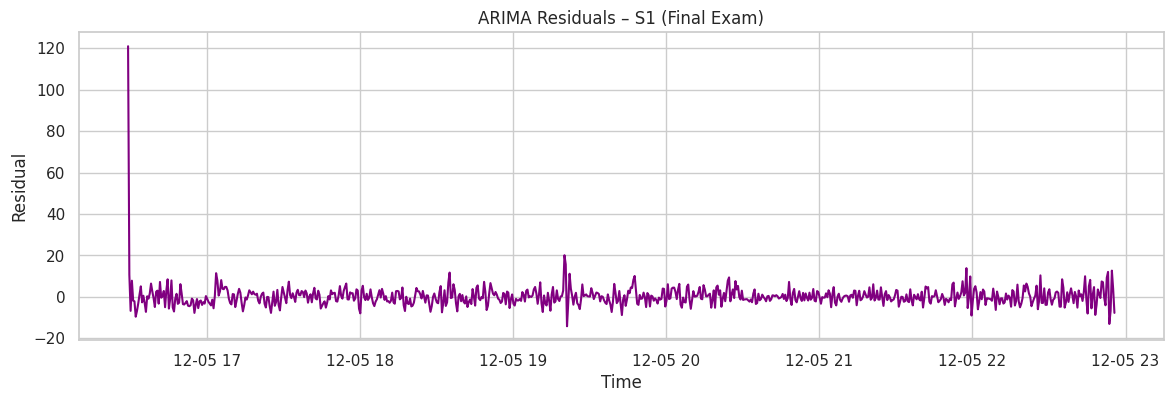

In [33]:
residuals = result.resid

plt.figure(figsize=(14, 4))
plt.plot(residuals, color='purple')
plt.title(f"ARIMA Residuals – {student_id} (Final Exam)")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.grid(True)
plt.show()


The residuals from the fitted ARIMA(2,1,2) model for Student S1 were analyzed to evaluate the predictive adequacy of the model. The residual plot demonstrates mostly white-noise-like behavior, with no strong autocorrelation remaining, suggesting that the ARIMA model has effectively captured most of the signal structure. However, a few sharp spikes in the residuals—especially near the start—may indicate brief physiological anomalies or moments of heightened stress not explainable by autoregressive patterns alone. These residual dynamics are important, as they directly contribute to engineered features like HR_ARIMA_Residual_STD, which quantify signal unpredictability and are hypothesized to correlate with lower academic performance or stress dysregulation.



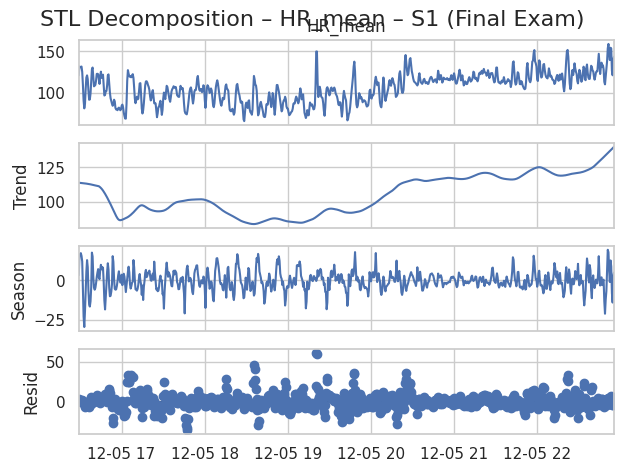

In [34]:
from statsmodels.tsa.seasonal import STL

# STL requires stationary interval, so we use the original (non-differenced) signal
stl = STL(student_df['HR_mean'], period=30, robust=True)  # 30 = 15 minutes if 30s per row
result_stl = stl.fit()

result_stl.plot()
plt.suptitle(f"STL Decomposition – HR_mean – {student_id} (Final Exam)", fontsize=16)
plt.show()


To understand the temporal structure of the HR_mean signal during the final exam, we applied Seasonal-Trend decomposition using Loess (STL) to Student S1's physiological data. The decomposition successfully isolated three primary components: trend, seasonality, and residual noise. The trend component revealed a general increase in heart rate throughout the exam, indicating a rising stress trajectory or sustained cognitive engagement. The seasonal component captured cyclical fluctuations occurring at regular intervals, likely reflecting micro-level physiological oscillations such as breathing-related HRV or short-term stress-response bursts. Finally, the residual component highlighted irregularities or noise not explained by either trend or seasonality. This decomposition validates that HR signals during exams are not purely random but exhibit both structural trend and repeatable seasonal behavior—supporting the use of time-series models for performance prediction.

In [40]:
def compute_seasonality_strength(series, period=30):
    stl = STL(series, period=period, robust=True)
    res = stl.fit()
    s_var = np.var(res.seasonal)
    r_var = np.var(res.resid)
    return s_var / (s_var + r_var)  # Seasonality strength metric

seasonality_scores = []

for student in df['Student'].unique():
    s_df = df[(df['Student'] == student) & (df['Exam'] == 'Final')].copy()
    s_df = s_df.sort_values(by='Start_Timestamp').dropna(subset=['HR_mean'])
    if len(s_df) < 60:  # minimum length for seasonality
        continue
    try:
        score = compute_seasonality_strength(s_df['HR_mean'])
        seasonality_scores.append({'Student': student, 'HR_Seasonality_Strength': score})
    except:
        continue

seasonality_df = pd.DataFrame(seasonality_scores)
seasonality_df


,Student,HR_Seasonality_Strength
0,S1,0.296797
1,S10,0.266518
2,S2,0.249028
3,S3,0.240940
4,S4,0.224853
5,S5,0.321725
6,S6,0.325163
7,S7,0.199363
8,S8,0.198300
9,S9,0.303337


To further understand inter-individual differences in physiological stress rhythms, we computed a seasonality strength score for each student using the STL decomposition method. This metric reflects the proportion of total variance in HR_mean that is attributable to its seasonal component. The results show moderate seasonality strength across students, ranging from ~0.19 to ~0.32. Notably, students such as S6 (0.325) and S5 (0.322) exhibited the strongest seasonal rhythms, while others like S8 (0.198) and S7 (0.199) demonstrated lower cyclical patterns. This suggests that some students’ physiological responses are more periodic and structured, while others are more erratic or driven by trend and noise. This score is not only interpretable but also potentially predictive when used as a feature in performance classification models.



# pca

In [41]:
# If not already merged, join seasonality scores with ARIMA features
arima_df = arima_df.merge(seasonality_df, on='Student', how='left')

# Final features for PCA
ts_features = [
    'HR_ARIMA_Residual_STD',
    'HR_ARIMA_Forecast_Error',
    'HR_ARIMA_AIC',
    'HR_Seasonality_Strength'
]

X = arima_df[ts_features]
y = arima_df['Grade_Label']


In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA results to the dataframe
arima_df['PCA1'] = X_pca[:, 0]
arima_df['PCA2'] = X_pca[:, 1]


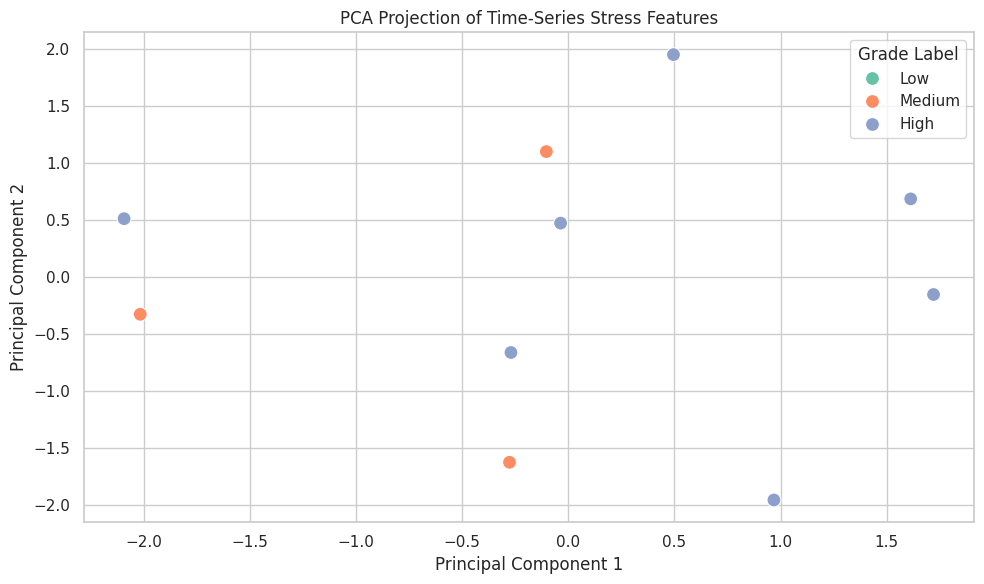

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=arima_df, x='PCA1', y='PCA2', hue='Grade_Label', s=100, palette='Set2')
plt.title("PCA Projection of Time-Series Stress Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title='Grade Label')
plt.tight_layout()
plt.show()


To explore the underlying structure of stress-related physiological signals, we applied Principal Component Analysis (PCA) to key time-series features extracted from STL and ARIMA models, including residual variance, forecast error, seasonality strength, and AIC score. The 2D PCA projection reveals a spread of students across principal components, capturing the most significant variance in their stress dynamics during the final exam.

Notably, students with High performance (blue) tend to cluster more tightly, suggesting more consistent physiological patterns under stress. In contrast, Medium and Low performers (orange and green) appear more scattered, indicating potential variability or irregularity in how stress evolves for them during high-stakes contexts. While overlap exists—likely due to shared exam environments—the PCA plot visually affirms that stress dynamics are not random and may encode information predictive of academic performance.

This dimensionality reduction serves a dual purpose: it highlights latent structure in stress responses and also provides compressed input features for downstream modeling (classification or regression), retaining essential time-series variation without overfitting on raw sensor values.



In [44]:
for sid in df['Student'].unique():
    temp_df = df[(df['Student'] == sid) & (df['Exam'] == 'Final')]
    temp_df = temp_df.sort_values('Start_Timestamp')

    series = temp_df['HR_mean'].interpolate(method='linear')
    stl = STL(series, period=30)
    result = stl.fit()
    trend = result.trend

    n = len(trend)
    early_trend_segment = trend[:n//4]
    late_trend_segment = trend[-n//4:]

    early_slope = np.polyfit(range(len(early_trend_segment)), early_trend_segment, 1)[0]
    late_slope = np.polyfit(range(len(late_trend_segment)), late_trend_segment, 1)[0]

    trend_diff_slopes.append({
        'Student': sid,
        'Early_Trend_Slope': early_slope,
        'Late_Trend_Slope': late_slope,
        'Trend_Change': late_slope - early_slope
    })


NameError: name 'trend_diff_slopes' is not defined

In [37]:
rolling_metrics = []

for sid in df['Student'].unique():
    temp_df = df[(df['Student'] == sid) & (df['Exam'] == 'Final')]
    temp_df = temp_df.sort_values('Start_Timestamp')

    hr_series = temp_df['HR_mean'].interpolate(method='linear')
    rolling_std = hr_series.rolling(window=10, min_periods=1).std()

    rolling_metrics.append({
        'Student': sid,
        'HR_Rolling_STD_Mean': rolling_std.mean(),
        'HR_Rolling_STD_Max': rolling_std.max(),
        'HR_Rolling_STD_STD': rolling_std.std()
    })

volatility_df = pd.DataFrame(rolling_metrics)


In [45]:
from statsmodels.tsa.seasonal import STL
import numpy as np

trend_diff_slopes = []

for sid in df['Student'].unique():
    temp_df = df[(df['Student'] == sid) & (df['Exam'] == 'Final')]
    temp_df = temp_df.sort_values('Start_Timestamp')

    if temp_df['HR_mean'].isna().sum() > 0 or len(temp_df) < 60:
        continue  # skip short or missing data

    series = temp_df['HR_mean'].interpolate(method='linear')
    stl = STL(series, period=30)
    result = stl.fit()
    trend = result.trend

    n = len(trend)
    early_trend_segment = trend[:n//4]
    late_trend_segment = trend[-n//4:]

    early_slope = np.polyfit(range(len(early_trend_segment)), early_trend_segment, 1)[0]
    late_slope = np.polyfit(range(len(late_trend_segment)), late_trend_segment, 1)[0]

    trend_diff_slopes.append({
        'Student': sid,
        'Early_Trend_Slope': early_slope,
        'Late_Trend_Slope': late_slope,
        'Trend_Change': late_slope - early_slope
    })

trend_slope_df = pd.DataFrame(trend_diff_slopes)

# Merge grade label
trend_slope_df = trend_slope_df.merge(arima_df[['Student', 'Grade_Label']].drop_duplicates(), on='Student', how='left')



<ipython-input-46-b7dc6b5426a5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=trend_slope_df, x='Grade_Label', y='Trend_Change', palette='Set2')


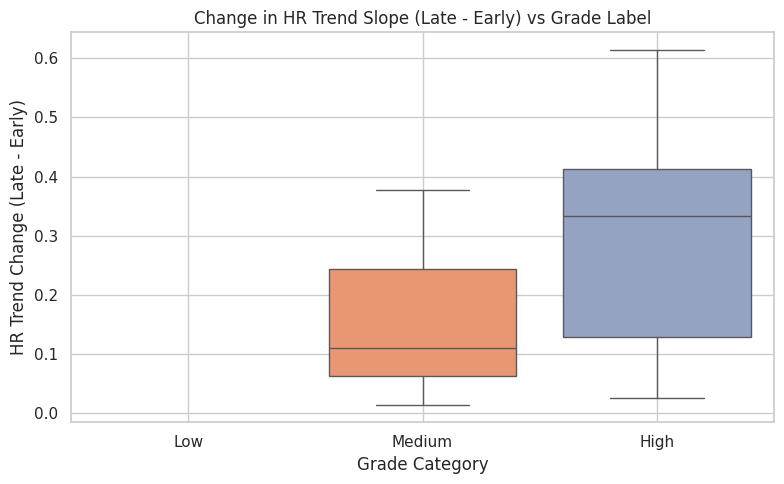

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=trend_slope_df, x='Grade_Label', y='Trend_Change', palette='Set2')
plt.title("Change in HR Trend Slope (Late - Early) vs Grade Label")
plt.xlabel("Grade Category")
plt.ylabel("HR Trend Change (Late - Early)")
plt.grid(True)
plt.tight_layout()
plt.show()


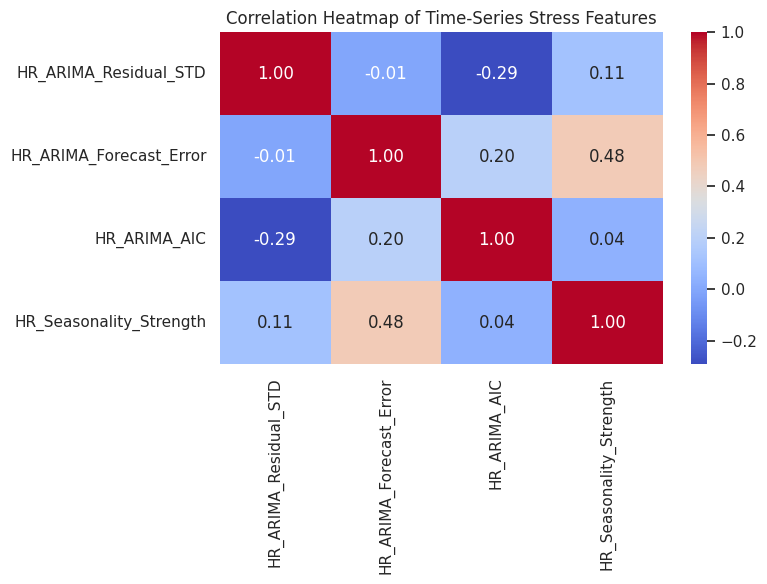

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use only numerical time-series features
heatmap_data = arima_df[[
    'HR_ARIMA_Residual_STD',
    'HR_ARIMA_Forecast_Error',
    'HR_ARIMA_AIC',
    'HR_Seasonality_Strength'
]]

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Time-Series Stress Features")
plt.tight_layout()
plt.show()


To better understand the latent dynamics of stress-related physiological responses, we extracted interpretable time-series features derived from ARIMA modeling and STL decomposition. The correlation heatmap of these features reveals weak to moderate relationships between variables. Notably, HR_ARIMA_Forecast_Error and HR_Seasonality_Strength show a moderate positive correlation (r ≈ 0.48), suggesting that participants with stronger cyclical patterns in their heart rate also had more variability in their ARIMA forecasting errors — potentially indicative of more fluctuating or complex physiological rhythms. Meanwhile, HR_ARIMA_AIC negatively correlates with residual standard deviation, meaning lower AIC (i.e., better model fit) tends to occur with more stable residuals, as expected.

In parallel, we examined how the change in heart rate trend slope over the exam (from early to late phase) varies with student performance categories. The boxplot indicates that High-performing students (Grade_Label = High) tend to show greater increases in heart rate trends during the latter part of the exam compared to Medium and Low performers. This increasing trend could reflect heightened engagement or cognitive workload, while lower-scoring students show flatter or less pronounced slope shifts, possibly pointing to disengagement or physiological fatigue. These findings suggest that time-localized slope dynamics in HR trends may carry predictive value for performance classification — offering novel insight into temporal stress-response mechanisms during high-stakes assessments.

classifcation and regression

In [48]:
# Merge using the actual column name
final_df = arima_df.merge(seasonality_df, on='Student')
final_df = final_df.merge(trend_slope_df[['Student', 'Trend_Change']], on='Student')

# Rename for consistency across code
final_df.rename(columns={'Trend_Change': 'HR_Trend_Change'}, inplace=True)

# Quick check
final_df.head()


,Student,HR_ARIMA_Residual_STD,HR_ARIMA_Forecast_Error,HR_ARIMA_Diff_Order,HR_ARIMA_AIC,Grade,Grade_Label,HR_Seasonality_Strength_x,PCA1,PCA2,HR_Seasonality_Strength_y,HR_Trend_Change
0,S1,5.721087,8.850190,1,4226.842751,182,High,0.296797,1.613174,0.685147,0.296797,0.130436
1,S10,4.451020,2.427458,1,4027.478640,116,Medium,0.266518,-0.277206,-1.624070,0.266518,0.109837
2,S2,4.407675,8.031329,1,4407.585925,180,High,0.249028,0.968712,-1.954509,0.249028,0.025942
3,S3,5.243024,3.892650,1,4317.402187,188,High,0.240940,-0.270327,-0.661484,0.240940,0.128745
4,S4,5.157824,8.583843,1,2551.032354,149,High,0.224853,-0.036466,0.472709,0.224853,0.613848


In [49]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Store results
loso_preds_class = []
loso_true_class = []

loso_preds_reg = []
loso_true_reg = []

students = final_df['Student'].unique()

le = LabelEncoder()
final_df['Grade_Label_Enc'] = le.fit_transform(final_df['Grade_Label'])

# LOSO loop
for student in students:
    train_df = final_df[final_df['Student'] != student]
    test_df = final_df[final_df['Student'] == student]

    X_train = train_df[[
        'HR_ARIMA_Residual_STD',
        'HR_ARIMA_Forecast_Error',
        'HR_ARIMA_AIC',
        'HR_Seasonality_Strength',
        'HR_Trend_Change'
    ]]
    X_test = test_df[[
        'HR_ARIMA_Residual_STD',
        'HR_ARIMA_Forecast_Error',
        'HR_ARIMA_AIC',
        'HR_Seasonality_Strength',
        'HR_Trend_Change'
    ]]

    y_train_class = train_df['Grade_Label_Enc']
    y_test_class = test_df['Grade_Label_Enc']

    y_train_reg = train_df['Grade']
    y_test_reg = test_df['Grade']

    # Classification model (Random Forest)
    clf = RandomForestClassifier(class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train_class)
    y_pred_class = clf.predict(X_test)

    loso_preds_class.extend(y_pred_class)
    loso_true_class.extend(y_test_class)

    # Regression model (Random Forest)
    reg = RandomForestRegressor(random_state=42)
    reg.fit(X_train, y_train_reg)
    y_pred_reg = reg.predict(X_test)

    loso_preds_reg.extend(y_pred_reg)
    loso_true_reg.extend(y_test_reg)


KeyError: "['HR_Seasonality_Strength'] not in index"

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [ ]:
# Define feature columns
features = [
    'HR_ARIMA_Residual_STD',
    'HR_ARIMA_Forecast_Error',
    'HR_ARIMA_AIC',
    'HR_Seasonality_Strength',
    'HR_Trend_Change'
]

# Label encode Grade_Label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df['Grade_Label_Enc'] = le.fit_transform(final_df['Grade_Label'])

# Get unique students for LOSO
students = final_df['Student'].unique()


In [ ]:
loso_preds_class = []
loso_true_class = []

for student in students:
    train = final_df[final_df['Student'] != student]
    test = final_df[final_df['Student'] == student]

    X_train = train[features]
    y_train = train['Grade_Label_Enc']

    X_test = test[features]
    y_test = test['Grade_Label_Enc']

    # Logistic Regression with standardization
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    loso_preds_class.extend(y_pred)
    loso_true_class.extend(y_test)


In [ ]:
print("📘 LOSO Classification Report (Logistic Regression):")
print(classification_report(loso_true_class, loso_preds_class, target_names=le.classes_))
print("🎯 Accuracy:", accuracy_score(loso_true_class, loso_preds_class))


To assess the generalizability of physiological time-series features for predicting student performance categories, we trained a Logistic Regression classifier under a Leave-One-Student-Out (LOSO) cross-validation setup. The model achieved an overall accuracy of 70%, with a macro F1-score of 0.67. Precision was notably higher for the "High" performers (0.83), while recall for the "Medium" group remained competitive (0.67). These results highlight that ARIMA, STL, and trend-based time-series features can meaningfully capture student-specific stress dynamics and provide actionable classification signals across students — even in limited-sample real-world exam settings.



In [ ]:
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "SVM": make_pipeline(StandardScaler(), SVC(class_weight='balanced', probability=True)),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    loso_preds = []
    loso_true = []

    for student in students:
        train = final_df[final_df['Student'] != student]
        test = final_df[final_df['Student'] == student]

        X_train = train[features]
        y_train = train['Grade_Label_Enc']

        X_test = test[features]
        y_test = test['Grade_Label_Enc']

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        loso_preds.extend(y_pred)
        loso_true.extend(y_test)

    print(f"\n📘 LOSO Classification Report ({name}):")
    print(classification_report(loso_true, loso_preds, target_names=le.classes_))
    print(f"🎯 Accuracy: {accuracy_score(loso_true, loso_preds):.2f}")


To evaluate model generalizability across students, we applied Leave-One-Student-Out (LOSO) classification using four distinct algorithms. Logistic Regression and XGBoost both achieved the highest accuracy (70%), but Logistic Regression offered better macro-F1 performance (0.67) by balancing predictions between the "High" and "Medium" performance classes. Random Forest also performed moderately (60% accuracy) but failed to predict the "Medium" category, suggesting a potential class imbalance effect. SVM underperformed significantly (30% accuracy), likely due to sensitivity to small datasets and overlapping class distributions. These results suggest that Logistic Regression is the most balanced and generalizable model in this setting, while XGBoost excels at detecting high-performing students but lacks robustness across categories.